In [20]:
from stl import mesh
from mpl_toolkits import mplot3d
from matplotlib import pyplot as plt
import numpy as np
import openmesh as om
import networkx as nx

In [21]:
%matplotlib widget

## Loading the mesh


In [101]:
# Loading the mesh
my_mesh_path = "./example_stl/bunnyReduced.stl"
my_mesh = mesh.Mesh.from_file(my_mesh_path)

In [102]:
# Details of the mesh
vertices = my_mesh.vectors.reshape(-1,3)
vertices = np.unique(vertices, axis=0)
vertex_count = vertices.shape[0]

face_count   = my_mesh.vectors.shape[0]

print("Vertex Count: {}".format(vertex_count))
print("Face Count: {}".format(face_count))

Vertex Count: 53
Face Count: 102


### Plot

In [103]:
def plot3d(vectors):
    figure = plt.figure()
    plt.ion()
    axes = mplot3d.Axes3D(figure)
    # Attach the Mesh to the plot
    poly_3d_collection = mplot3d.art3d.Poly3DCollection(vectors)
    poly_3d_collection.set_edgecolors('black')
    axes.add_collection3d(poly_3d_collection)
    # Auto scale to the mesh size
    scale = my_mesh.points.flatten()
    axes.auto_scale_xyz(scale, scale, scale)
    # Show the plot to the screen
    plt.show()

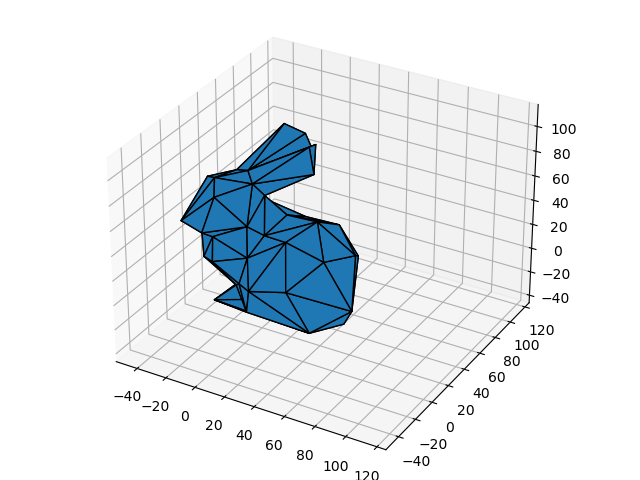

In [104]:
# Create a new plot
plot3d(my_mesh.vectors)

In [105]:
def openmesh_to_numpy_stl(om_mesh):
    return None

---

## Unfold the mesh

### 1. Read the Data by OpenMesh

In [106]:
# Read the mesh with openmesh for data structure utility
om_mesh = om.read_trimesh(my_mesh_path)
print("numEdges = {}".format(om_mesh.n_edges()))
print("numVertices = {}".format(om_mesh.n_vertices()))
print("numFaces = {}".format(om_mesh.n_faces()))

numEdges = 153
numVertices = 53
numFaces = 102


### 2. Create The Dual Graph

#### 2.1 Function to calculate Dual Graph Edge weight

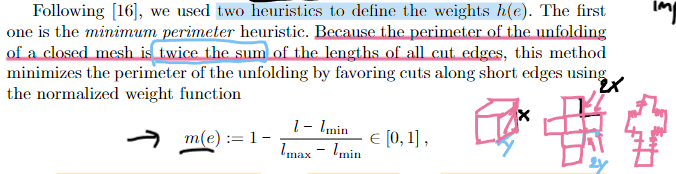

In [107]:
# Function to Calculate the Edge weight in dual graph
def calculate_dual_weight(edge, minLength, maxLength, om_mesh):
    edge_length = om_mesh.calc_edge_length(edge)
    weight = 1.0 - ( (edge_length - minLength)/(maxLength - minLength) )
    return weight

#### 2.2 Create Dual Graph

In [108]:
# Calculate the min and max edge length for weight calculation
minLength = 1000
maxLength = 0
for edge in om_mesh.edges():
    edgelength = om_mesh.calc_edge_length(edge) # OpenMesh : Get Edge Length
    if edgelength < minLength:
        minLength = edgelength
    if edgelength > maxLength:
        maxLength = edgelength

In [109]:
# Create Dual Graph
dual_graph = nx.Graph()

# Traverse the mesh by its adjacent face
# We need to traverse by using half edges for adjacent faces
for edge in om_mesh.edges():
    # Find the Halfedge of the edge
    halfedge_0 = om_mesh.halfedge_handle(edge, 0)
    halfedge_1 = om_mesh.halfedge_handle(edge, 1)
    
    # Extract Face corresponds to these halfedges
    face0 = om_mesh.face_handle(halfedge_0)
    face1 = om_mesh.face_handle(halfedge_1)
    
    dual_graph_edge_weight = calculate_dual_weight(edge, minLength, maxLength, om_mesh)
    
    center1 = (0, 0)
    for vertex in om_mesh.fv(face0):
        center1 = center1 + 0.3333333333333333 * np.array([om_mesh.point(vertex)[0], om_mesh.point(vertex)[2]])
    center2 = (0, 0)
    for vertex in om_mesh.fv(face1):
        center2 = center2 + 0.3333333333333333 * np.array([om_mesh.point(vertex)[0], om_mesh.point(vertex)[2]])

    # [4.5] Add the EDGE and "TWO NODES" to the dual graph
    # - Füge die neuen Knoten und Kante zum dualen Graph hinzu
    dual_graph.add_node(face0.idx(), pos=center1)
    dual_graph.add_node(face1.idx(), pos=center2)
    
    dual_graph.add_edge(face0.idx(), face1.idx(), idx=edge.idx(), weight=dual_graph_edge_weight)

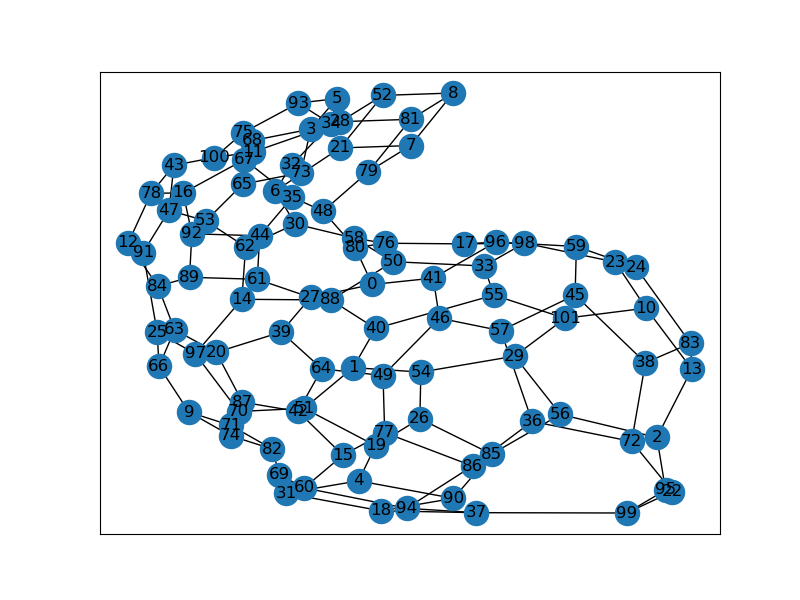

In [110]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6));
pos=nx.get_node_attributes(dual_graph,'pos')
nx.draw_networkx(dual_graph,pos)

#### 2.3 Create Minimum Spanning Tree

In [111]:
spanning_tree = nx.minimum_spanning_tree(dual_graph)

In [112]:
spanning_tree.edges()

EdgeView([(0, 27), (27, 39), (27, 61), (41, 46), (80, 76), (80, 48), (1, 40), (1, 51), (1, 54), (51, 70), (40, 88), (2, 95), (2, 56), (2, 13), (56, 85), (56, 29), (13, 83), (3, 68), (3, 5), (73, 32), (68, 75), (68, 65), (4, 19), (4, 90), (90, 18), (31, 18), (31, 69), (34, 32), (34, 93), (93, 75), (6, 21), (6, 32), (30, 62), (21, 7), (21, 52), (8, 81), (79, 81), (79, 48), (81, 28), (52, 28), (9, 66), (74, 82), (74, 70), (71, 87), (66, 25), (66, 63), (10, 101), (23, 24), (101, 29), (101, 55), (11, 67), (11, 100), (67, 35), (100, 43), (12, 78), (12, 91), (12, 84), (84, 63), (84, 89), (78, 16), (91, 47), (83, 38), (83, 24), (14, 88), (14, 62), (14, 97), (88, 50), (97, 25), (15, 77), (42, 87), (42, 64), (60, 94), (77, 86), (16, 92), (92, 44), (17, 96), (17, 98), (98, 33), (18, 37), (37, 94), (37, 99), (26, 85), (20, 63), (39, 64), (22, 72), (72, 38), (72, 36), (24, 59), (61, 44), (58, 50), (69, 82), (33, 55), (35, 48), (35, 44), (36, 86), (86, 94), (57, 46), (57, 45), (38, 45), (46, 49), (4

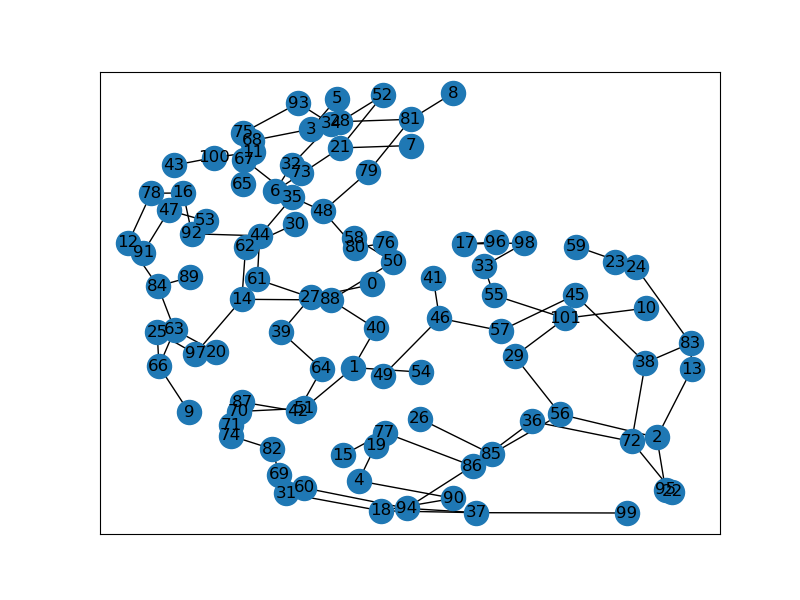

In [113]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6));
pos=nx.get_node_attributes(spanning_tree,'pos')
nx.draw_networkx(spanning_tree, pos)

#### 2.4 Unfold the Spanning Tree

https://math.stackexchange.com/questions/543961/determine-third-point-of-triangle-when-two-points-and-all-sides-are-known

In [114]:
def getThirdPoint(v0, v1, l01, l12, l20):
    v2rotx = (l01 ** 2 + l20 ** 2 - l12 ** 2) / (2 * l01)
    v2roty0 = np.sqrt((l01 + l20 + l12) * (l01 + l20 - l12) * (l01 - l20 + l12) * (-l01 + l20 + l12)) / (2 * l01)

    v2roty1 = - v2roty0

    theta = np.arctan2(v1[1] - v0[1], v1[0] - v0[0])

    v2trans0 = np.array(
        [v2rotx * np.cos(theta) - v2roty0 * np.sin(theta), v2rotx * np.sin(theta) + v2roty0 * np.cos(theta), 0])
    v2trans1 = np.array(
        [v2rotx * np.cos(theta) - v2roty1 * np.sin(theta), v2rotx * np.sin(theta) + v2roty1 * np.cos(theta), 0])
    return [v2trans0 + v0, v2trans1 + v0]

In [115]:
# Generate Edge Number (for merging the edges) and Folding Direction
def addVisualisationData(mesh, unfoldedMesh, originalHalfedges, unfoldedHalfedges, glueNumber, foldingDirection):
    # Traverse for all halfedge in the face (3 edges)
    for i in range(3):
        # Find the Normal of Two Faces and decided
        if mesh.calc_dihedral_angle(originalHalfedges[i]) < 0:
            foldingDirection[unfoldedMesh.edge_handle(unfoldedHalfedges[i]).idx()] = -1
        else:
            foldingDirection[unfoldedMesh.edge_handle(unfoldedHalfedges[i]).idx()] = 1

        # Edge in Unfolded is what edge in original mesh
        glueNumber[unfoldedMesh.edge_handle(unfoldedHalfedges[i]).idx()] = mesh.edge_handle(originalHalfedges[i]).idx()

In [116]:
def unfold_spanning_tree(om_mesh, spanning_tree):
    """
    Given OpenMesh object and Nx's Spanning Tree of Dual Graph
    Return New OpenMesh object of Unfolded Mesh
    """
    # Create New result mesh 
    unfolded_mesh = om.TriMesh()
    
    # Old mesh detail
    original_face_count = om_mesh.n_faces()
    tree_size = spanning_tree.number_of_edges()
    
    # How Many Edge to draw after Unfold
    num_unfolded_edge = (3*original_face_count) - tree_size
    
    # Arrays 
    # - Detemines is this folding or cut
    is_folding_edge = np.zeros(num_unfolded_edge, dtype=bool)
    # - Gluing Edge (which edge need to glue together)
    glue_number     = np.zeros(num_unfolded_edge, dtype=int)
    # - Folded or Creased Edge (which edge need to be folded or creased)
    folding_type    = np.zeros(num_unfolded_edge, dtype=int)
    # - Connections between faces, connections[face_idx] = face
    connections = np.empty(original_face_count, dtype=int)
    
    # Start Now ! from Spanning Tree
    # Node = faces
    # Edge = edge adjacent, cousing by two faces
    starting_node = list(spanning_tree.nodes())[0] # Select from Spanning Tree
    starting_triangle = om_mesh.face_handle(starting_node) # Face = Triangle -w-" # ON ORIGINAL MESH
    
    # Start Edge Traversal
    # - Start from the first face selected and find its halfedge
    first_halfedge  = om_mesh.halfedge_handle(starting_triangle)     # ON ORIGINAL MESH
    second_halfedge = om_mesh.next_halfedge_handle(first_halfedge)   # ON ORIGINAL MESH
    third_halfedge  = om_mesh.next_halfedge_handle(second_halfedge)  # ON ORIGINAL MESH
    # Store pointer for drawing
    original_halfedges = [first_halfedge, second_halfedge, third_halfedge]  # ON ORIGINAL MESH
    
    # Storing Edge Length
    edge_length = [om_mesh.calc_edge_length(first_halfedge), om_mesh.calc_edge_length(second_halfedge),
                   om_mesh.calc_edge_length(third_halfedge)] # ON ORIGINAL MESH
    
    # Store FIRST Point for drawing 
    first_unfolded_point = np.array([0, 0, 0])  # ON UNFOLDED WORLD
    # Store SECOND Point for drawing
    second_unfolded_point = np.array([edge_length[0], 0, 0]) # ON UNFOLDED WORLD
    # Store THIRD Point for drawing
    # - Third Point comes from calculation
    [thirdUnfolded0, thirdUnfolded1] = getThirdPoint(
        first_unfolded_point, second_unfolded_point, 
        edge_length[0], edge_length[1], edge_length[2]
    ) # ON UNFOLDED WORLD
    
    # Use the inside Point as the third point
    if thirdUnfolded0[1] > 0:
        third_unfolded_point = thirdUnfolded0 # ON UNFOLDED WORLD
    else:
        third_unfolded_point = thirdUnfolded1 # ON UNFOLDED WORLD
    
    # Create Triangle for the first face drawn to canvas
    firstUnfoldedVertex = unfolded_mesh.add_vertex(first_unfolded_point)    # ON UNFOLDED MESH
    secondUnfoldedVertex = unfolded_mesh.add_vertex(second_unfolded_point)  # ON UNFOLDED MESH
    thirdUnfoldedVertex = unfolded_mesh.add_vertex(third_unfolded_point)    # ON UNFOLDED MESH
    unfolded_face = unfolded_mesh.add_face(firstUnfoldedVertex, secondUnfoldedVertex, thirdUnfoldedVertex)
    
    # Create Connection from the face in unfold world and original mesh
    connections[unfolded_face.idx()] = starting_triangle.idx()   # LINK ORIGINAL and UNFOLDED
    
    # Create Halfedge for the first unfolded face to next face
    firstUnfoldedHalfEdge = unfolded_mesh.next_halfedge_handle(
        unfolded_mesh.opposite_halfedge_handle(
            unfolded_mesh.halfedge_handle(firstUnfoldedVertex)
    ))
    secondUnfoldedHalfEdge = unfolded_mesh.next_halfedge_handle(firstUnfoldedHalfEdge)
    thirdUnfoldedHalfEdge = unfolded_mesh.next_halfedge_handle(secondUnfoldedHalfEdge)
    unfoldedHalfEdges = [firstUnfoldedHalfEdge, secondUnfoldedHalfEdge, thirdUnfoldedHalfEdge]

    halfEdgeConnections = {first_halfedge.idx(): firstUnfoldedHalfEdge.idx(),
                           second_halfedge.idx(): secondUnfoldedHalfEdge.idx(),
                           third_halfedge.idx(): thirdUnfoldedHalfEdge.idx()}

    # Create Crease and Folded including remember glue number for first triangle
    addVisualisationData(om_mesh, unfolded_mesh, original_halfedges, unfoldedHalfEdges, glue_number, folding_type)

    
    ##########################
    # DUAL GRAPH TRAVERSAL
    ##########################
    for dualEdge in nx.dfs_edges(spanning_tree, source=starting_node):
        foldingEdge = om_mesh.edge_handle(spanning_tree[dualEdge[0]][dualEdge[1]]['idx'])
        # [6.15.1] Find the Correspond half edge in the starting triangle
        # Finde die dazugehörige Halbkante im AusgangsDreieck
        foldingHalfEdge = om_mesh.halfedge_handle(foldingEdge, 0)
        if not (om_mesh.face_handle(foldingHalfEdge).idx() == dualEdge[0]):
            foldingHalfEdge = om_mesh.halfedge_handle(foldingEdge, 1)

        # [6.15.2] Find the corresponding unfolded halfedge
        # Finde die dazugehörige abgewickelte Halbkante
        unfoldedLastHalfEdge = unfolded_mesh.halfedge_handle(halfEdgeConnections[foldingHalfEdge.idx()])

        # [6.15.4] # We turn over the half-edges to lie in the new triangle
        # Wir drehen die Halbkanten um, um im neuen Dreieck zu liegen
        foldingHalfEdge = om_mesh.opposite_halfedge_handle(foldingHalfEdge)
        unfoldedLastHalfEdge = unfolded_mesh.opposite_halfedge_handle(unfoldedLastHalfEdge)

        # [6.15.5] # The two corners of the folded edge
        # Die beiden Ecken der Faltkante
        unfoldedFromVertex = unfolded_mesh.from_vertex_handle(unfoldedLastHalfEdge)
        unfoldedToVertex = unfolded_mesh.to_vertex_handle(unfoldedLastHalfEdge)

        # [6.15.6] # Calculate the edge lengths in the new triangle
        # Berechne die Kantenlängen im neuen Dreieck
        secondHalfEdgeInFace = om_mesh.next_halfedge_handle(foldingHalfEdge)
        thirdHalfEdgeInFace = om_mesh.next_halfedge_handle(secondHalfEdgeInFace)

        originalHalfEdges = [foldingHalfEdge, secondHalfEdgeInFace, thirdHalfEdgeInFace]

        edgelengths = [om_mesh.calc_edge_length(foldingHalfEdge), om_mesh.calc_edge_length(secondHalfEdgeInFace),
                       om_mesh.calc_edge_length(thirdHalfEdgeInFace)]

        # [6.15.7] # We calculate the two possibilities for the third point in the triangle
        # Like [6.9] # [6.9] Calculate the third point to be placed in unfolded mesh - Theres two possibilities
        # Wir berechnen die beiden Möglichkeiten für den dritten Punkt im Dreieck
        [newUnfoldedVertex0, newUnfoldedVertex1] = getThirdPoint(unfolded_mesh.point(unfoldedFromVertex),
                                                                 unfolded_mesh.point(unfoldedToVertex), edgelengths[0],
                                                                 edgelengths[1], edgelengths[2])


        newUnfoldedVertex = unfolded_mesh.add_vertex(newUnfoldedVertex0)

        # Make the face
        newface = unfolded_mesh.add_face(unfoldedFromVertex, unfoldedToVertex, newUnfoldedVertex)

        secondUnfoldedHalfEdge = unfolded_mesh.next_halfedge_handle(unfoldedLastHalfEdge)
        thirdUnfoldedHalfEdge = unfolded_mesh.next_halfedge_handle(secondUnfoldedHalfEdge)
        unfoldedHalfEdges = [unfoldedLastHalfEdge, secondUnfoldedHalfEdge, thirdUnfoldedHalfEdge]

        # Saving the information about edges and side
        # Dashed line in the output
        # - Speichern der Informationen über Kanten und Seite
        # - Gestrichelte Linie in der Ausgabe
        unfoldedLastEdge = unfolded_mesh.edge_handle(unfoldedLastHalfEdge)
        is_folding_edge[unfoldedLastEdge.idx()] = True

        # Glue number and folding direction
        # - Klebenummer und Faltrichtung
        addVisualisationData(om_mesh, unfolded_mesh, originalHalfEdges, unfoldedHalfEdges, glue_number, folding_type)

        # Associated page
        # - Zugehörige Seite
        connections[newface.idx()] = dualEdge[1]

        # Identify the half-edges
        # - Identifiziere die Halbkanten
        for i in range(3):
            halfEdgeConnections[originalHalfEdges[i].idx()] = unfoldedHalfEdges[i].idx()

    return [unfolded_mesh, is_folding_edge, connections, glue_number, folding_type]

Unfolding

In [117]:
fullUnfolding = unfold_spanning_tree(om_mesh, spanning_tree)

In [118]:
# [unfolded_mesh, is_folding_edge, connections, glue_number, folding_type]
fullUnfolding

 array([False,  True, False,  True,  True, False,  True,  True, False,
         True, False, False,  True, False, False,  True, False,  True,
         True,  True,  True,  True,  True, False,  True, False, False,
        False,  True,  True,  True,  True, False, False,  True,  True,
         True, False, False, False,  True,  True,  True, False,  True,
        False,  True,  True, False,  True,  True, False, False,  True,
        False, False, False, False, False, False, False,  True, False,
        False,  True, False,  True, False, False,  True, False, False,
         True, False,  True,  True,  True,  True, False, False,  True,
        False, False,  True,  True,  True,  True,  True,  True, False,
         True,  True, False,  True,  True,  True,  True, False,  True,
         True,  True, False,  True,  True, False,  True, False,  True,
        False,  True, False, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,
      

In [119]:
def findBoundingBox(mesh):
    firstpoint = mesh.point(mesh.vertex_handle(0))
    xmin = firstpoint[0]
    xmax = firstpoint[0]
    ymin = firstpoint[1]
    ymax = firstpoint[1]
    for vertex in mesh.vertices():
        coordinates = mesh.point(vertex)
        if (coordinates[0] < xmin):
            xmin = coordinates[0]
        if (coordinates[0] > xmax):
            xmax = coordinates[0]
        if (coordinates[1] < ymin):
            ymin = coordinates[1]
        if (coordinates[1] > ymax):
            ymax = coordinates[1]
    boxSize = np.maximum(np.abs(xmax - xmin), np.abs(ymax - ymin))

    return [xmin, ymin, boxSize]

In [120]:
def writeSVG(filename, unfolding, size, printNumbers):
    mesh = unfolding[0]
    isFoldingEdge = unfolding[1]
    glueNumber = unfolding[3]
    foldingDirection = unfolding[4]

    # Berechne die bounding box
    [xmin, ymin, boxSize] = findBoundingBox(unfolding[0])

    if size > 0:
        boxSize = size

    strokewidth = 0.002 * boxSize
    dashLength = 0.008 * boxSize
    spaceLength = 0.02 * boxSize

    textDistance = 0.02 * boxSize
    textStrokewidth = 0.05 * strokewidth
    fontsize = 0.015 * boxSize

    frame = 0.05 * boxSize

    # Öffne Datei im Schreibmodus (write)
    file = open(filename, 'w')

    # Schreibe xml-header
    file.write("<?xml version=\"1.0\" encoding=\"UTF-8\" standalone=\"no\"?>\n")

    # Die Papiergröße und die Skalierung
    file.write("<svg width=\"30.5cm\" height=\"30.5cm\" viewBox = \"" + str(xmin - frame) + " " + str(
        ymin - frame) + " " + str(boxSize + 2 * frame) + " " + str(
        boxSize + 2 * frame) + "\" version = \"1.1\" xmlns=\"http://www.w3.org/2000/svg\">\n")

    # Gehe über alle Kanten des GItters
    for edge in mesh.edges():
        # Die beiden Endpunkte
        he = mesh.halfedge_handle(edge, 0)
        vertex0 = mesh.point(mesh.from_vertex_handle(he))
        vertex1 = mesh.point(mesh.to_vertex_handle(he))

        # Schreibe eine Gerade zwischen den beiden Ecken
        file.write("<path d =\"M " + str(vertex0[0]) + "," + str(vertex0[1]) + " " + str(vertex1[0]) + "," + str(
            vertex1[1]) + "\" style=\"fill:none;stroke:")

        # Farbe je nach Faltrichtung
        if foldingDirection[edge.idx()] > 0:
            file.write("#ff0000")
        elif foldingDirection[edge.idx()] < 0:
            file.write("#0066ff")

        file.write(";stroke-width:" + str(
            strokewidth) + ";stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:4;stroke-dasharray:")

        # Gestrichelte Linien für Faltkanten
        if isFoldingEdge[edge.idx()]:
            file.write((str(dashLength) + ", " + str(spaceLength)))
        else:
            file.write("none")

        file.write(";stroke-dashoffset:0;stroke-opacity:1")
        file.write("\" />\n")

        # Die Nummer der Kante, mit der zusammengeklebt wird
        if not isFoldingEdge[edge.idx()]:
            # Find halfedge in the face
            halfEdge = mesh.halfedge_handle(edge, 0)
            if mesh.face_handle(halfEdge).idx() == -1:
                halfEdge = mesh.opposite_halfedge_handle(halfEdge)
            vector = mesh.calc_edge_vector(halfEdge)
            # normalize
            vector = vector / np.linalg.norm(vector)
            midPoint = 0.5 * (
                    mesh.point(mesh.from_vertex_handle(halfEdge)) + mesh.point(mesh.to_vertex_handle(halfEdge)))
            rotatedVector = np.array([-vector[1], vector[0], 0])
            angle = np.arctan2(vector[1], vector[0])
            position = midPoint + textDistance * rotatedVector
            rotation = 180 / np.pi * angle

            if (printNumbers):
                file.write("<text x=\"" + str(position[0]) + "\" y=\"" + str(position[1]) + "\" font-size=\"" + str(
                    fontsize) + "\" stroke-width=\"" + str(textStrokewidth) + "\" transform=\"rotate(" + str(
                    rotation) + "," + str(position[0]) + "," + str(position[1]) + ")\">" + str(
                    glueNumber[edge.idx()]) + "</text>\n")

    file.write("</svg>")
    file.close()

In [121]:
writeSVG("test.svg", fullUnfolding, findBoundingBox(fullUnfolding[0])[2], True)